# WTF 深度强化学习教程 1. Deep Q-Network

WTF 深度强化学习教程，帮助新人快速入门 Deep RL，算法使用pytorch 2.0版本实现。

**推特**：[@WTFAcademy_](https://twitter.com/WTFAcademy_) ｜ [@0xAA_Science](https://twitter.com/0xAA_Science)

**WTF Academy 社群：** [官网 wtf.academy](https://wtf.academy/) | [WTF Solidity 教程](https://github.com/AmazingAng/WTFSolidity) | [discord](https://discord.wtf.academy/) | [微信群申请](https://docs.google.com/forms/d/e/1FAIpQLSe4KGT8Sh6sJ7hedQRuIYirOoZK_85miz3dw7vA1-YjodgJ-A/viewform?usp=sf_link)

所有代码和教程开源在 github: [github.com/AmazingAng/WTF-DeepRL](https://github.com/WTFAcademy/WTF-DeepRL)

---

这一讲，我们将尝试利用pytorch实现深度强化学习的开山之作 Deep Q-Network，DQN，推荐你先阅读 [DQN 论文](https://arxiv.org/abs/1312.5602)。

## 0. 先修课程

在开始之前，你需要先完成先修课程：

1. 强化学习理论：推荐 Sutton 和 Barto 写的[强化学习圣经](http://incompleteideas.net/book/RLbook2020.pdf)。

    ![](./img/1-1.png)

2. 机器学习：你可以在网上找到很多机器学习的公开课，比如coursera上Andrew Ng的课程。

3. python编程：网上你可以找到很多的python入门公开课，我推荐哈佛大学的CS50 python版。

## 1. 深度强化学习中的元素

强化学习研究的是智能体（Agent）和环境（Environment）交互中如何学习最优策略，以获得最大收益（Cumulative rewards）。Agent需要能够观察环境(observe)的到所处的状态，评判（value）状态下每个动作的价值，选出最优的动作（act）来和环境交互，同时通过从经验中学习不断改善自己的策略（learn from experience）。因此，observe，value，act和learn是强化学习Agent必不可少的元素。

![](./img/1-2.png)

如果我们给Agent写一个类，大体会长这样的：

```python
class Agent: 

    def __init__(self):
        ...

    def observe(self, observation):
        ...
        return state

    def value(self, state,):
        ...
        return value_of_actions
    
    def act(value_of_actions):
        ...
        return selected_action
    
    def learn_from_experience(self, batch_size):
        ...
```

这个教程中，我们会使用经典的Atari游戏来训练强化学习算法，下面我们探讨一下这几个函数在Atari环境中起到什么作用：

- `observe`: 在Atari中，环境每一步给出的observation（84x84x1的array）可以直接作为state。那么observe()函数只需要把numpy array转换为torch tensor，方便模型后续使用就好了。在更复杂的partial observable环境，我们需要利用observation来推断所处的state，这时observe()函数会由更多功能。
- `value`: 在DQN中，`value`函数主要是给出当前state下每个action的Q value，帮助智能体选择最优策略。
- `act`: 在DQN中，根据`value`函数给出的Q值，采用epsilon greedy policy选出action。
- `learn_from_experience`: 根据收集的经验计算TD Loss（temporal-difference loss），再通过梯度下降算法更新深度神经网络的参数，改善策略。其中TD Loss由Bellman Equation给出：

    $$Loss_{TD}=R_t+\gamma Q(s_{t+1},a_{t+1})−Q(s_t,a_t)$$

下面，我们开始完成DQN算法。

## 2. 引入包
你需要安装相应的包，然后在 jupyter notebook 中导入他们，如果你使用的是Google Colab Research，则需要安装`gym[atari]`和`autorom[accept-rom-license]`。

In [ ]:
# 在 Google Colab Rsearch 中需要安装的库
# !pip install gym[atari]
# !pip install autorom[accept-rom-license]

import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from gym.wrappers import AtariPreprocessing, LazyFrames, FrameStack

from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=69b44dc7b1b1aad6cb9ea5a7645a7e43a5bca71ceea9b759f5e4a94cb5f9cbb6
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


## 3. Atari游戏中的Pong

Pong是Atari中一个仿真打乒乓球的游戏：玩家和电脑每人拿一个板子，接对方弹来的球，没接住的话，对方得一分，先得到21分的获胜。

我们使用 DQN 论文中的设定，在丢失声明时会结束游戏，并且4帧画面会合并为1个输入，加快学习。

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


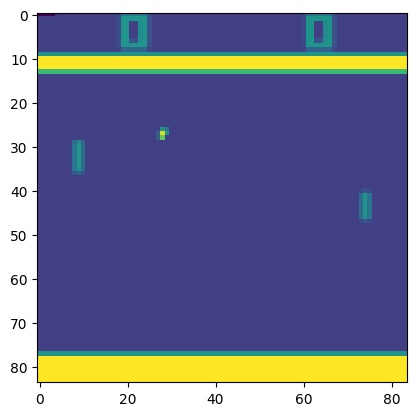

In [24]:
# Create and wrap the environment
env = gym.make('PongNoFrameskip-v4')
env = AtariPreprocessing(env,
                         scale_obs=False,
                         terminal_on_life_loss=True,
                         )
env = FrameStack(env, num_stack=4)
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test.__array__()[0,...])

# env.close()

## 4. Deep-Q Network

对于复杂的问题，state维度非常大，我们很难基于tabular method来判断每一个(state, action)的价值。这种情况下，我们利用function approximation方法，构建一个深度神经网络(Deep-Q Network, DQN)，来估计(state, action)的价值。value()中Deep-Q Network模块就是一个神经网络，输入是atari game中的一帧图像，输出是每个action的价值。

In [25]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.reshape(x.size(0), -1)))
        return self.fc5(x)


## 5. Memory
因为深度神经网络收敛很慢，需要非常多的样本，如果只根据环境交互来训练网络，将非常的没效率。因此DQN引入了一个memory buffer来进行memory replay，就是把之前和环境交互的经验存下来，在训练时重复利用。memory buffer主要实现两个函数：`push`函数将经验存入，`sample`函数将经验取出用于训练。

In [26]:
class Memory_Buffer(object):
    def __init__(self, memory_size=100000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0

    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):

            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones

    def size(self):
        return len(self.buffer)


## 6. Agent

下面，我们要写最复杂的部分，实现基于DQN的智能体。我们分别实现了下列函数：

- `__init__`: 初始化DQN智能体的参数和网络。
- `observe`: 将Atari环境每一步返回的observation（numpy矩阵）转为状态（pytorch tensor）。
- `value`: 返回状态的Q值。
- `act`: 给定状态，根据epsilon greedy算法给出当前动作。
- `sample_from_buffer`: 学习相关，从memory buffer抽样经验。
- `compute_td_loss`: 学习相关，利用从memory buffer抽样的经验计算TD Loss。
- `learn_from_experience`: 学习相关，利用TD Loss进行梯度下降，优化网络。

In [28]:
class DQNAgent:
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())

        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe.__array__()[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values

    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton

    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]

        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss

    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)


## 7. Traning

接下来是最重要的训练部分，基本上就是定好初始参数，要训练的总帧数，然后让智能体与环境交互并学习。

In [ ]:
# if __name__ == '__main__':

# Training DQN in PongNoFrameskip-v4
env = gym.make('PongNoFrameskip-v4')
env = AtariPreprocessing(env,
                         scale_obs=False,
                         terminal_on_life_loss=True,
                         )
env = FrameStack(env, num_stack=4)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.05
eps_decay = 30000
frames = 2000000
USE_CUDA = False
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[1]
state_channel = env.observation_space.shape[0]
agent = DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate, memory_size = max_buff)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DQN_stackframe", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)

    next_frame, reward, done ,_ = env.step(action)

    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame

    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)

    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())

    if done:

        frame = env.reset()

        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0
frames:  1000, reward: -20.000000, loss: 0.000000, epsilon: 0.968855, episode:    1
frames:  2000, reward: -20.000000, loss: 0.000000, epsilon: 0.938732, episode:    1
frames:  3000, reward: -20.000000, loss: 0.000000, epsilon: 0.909596, episode:    3
frames:  4000, reward: -20.250000, loss: 0.000000, epsilon: 0.881415, episode:    4
frames:  5000, reward: -19.800000, loss: 0.000000, epsilon: 0.854158, episode:    5
frames:  6000, reward: -20.000000, loss: 0.000000, epsilon: 0.827794, episode:    6
frames:  7000, reward: -20.142857, loss: 0.000000, epsilon: 0.802295, episode:    7
frames:  8000, reward: -20.333333, loss: 0.000000, epsilon: 0.777632, episode:    9
frames:  9000, reward: -20.400000, loss: 0.000000, epsilon: 0.753777, episode:   10
frames: 10000, reward: -20.500000, loss: 0.015006, epsilon: 0.730705, episode:   11
frames: 11000, reward: -20.600000, loss: 0.015339, epsilon: 0.708389, episode:   

## Results

下面我们使用matplotlib库画出游戏得分和loss曲线。

从左边的图我们可以看到，DQN智能体在玩了200把游戏后开始快速学习，大概在300把游戏之后学习成功（达到20+分）。

从右边的图我们可以看到，在表现达到最优之后，Loss还是在不断减小。

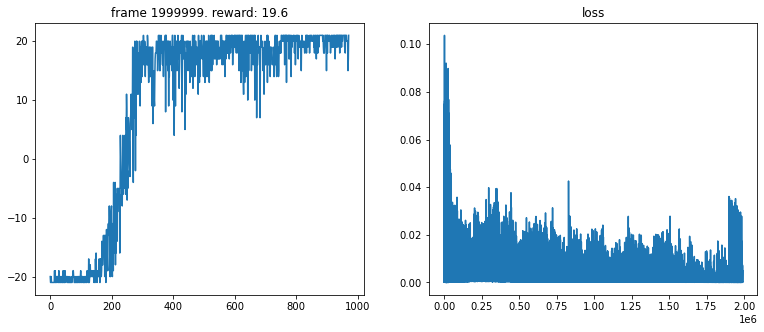

In [ ]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)

In [ ]:
## 总结

感想就是，总结强化学习需要的元素相对容易，真正实现的时候很麻烦，尤其是当模型学不会的时候，你会怀疑是模型的问题还是代码有bug，不要犹豫，是代码有bug。

训练模型收敛大概需要2百万步，差不多要24小时+，比较慢，但是很欣慰的是Pong在atari game中是最容易实现的游戏，没有bug的话可以在10小时以内收敛，很良心。

DQN算法非常经典，值得学习，建议大家都自己实现一遍。